# Model Training

Train Decision Tree and Random Forest WITHOUT proxy features; use only features that work on both 5k and 2k naturally

In [1]:

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path


# LOAD PROCESSED 5K DATASET

processed_data_path = Path("../data/processed")
df_5k = pd.read_csv(processed_data_path/'5k_with_proxies.csv')
print(f"\nLoaded 5k dataset: {df_5k.shape}")


Loaded 5k dataset: (50, 33)


# Select Features

No proxy features since proxy failed in Notebook 3. 

In [2]:
features_to_use = [
    'variance_to_expected',     # 10.02x lift - CRITICAL ***
    'duration_minutes',          # 2.07x lift - IMPORTANT *
    'wait_time_minutes',         # 1.65x lift - IMPORTANT *
    'handoff_count_so_far',      # 0.97x lift - WEAK but available
    'hour_of_day',               # Temporal pattern
    'sla_breached',              # Business context
]

print("\nFeatures for modeling:")
for i, feat in enumerate(features_to_use, 1):
    if feat in df_5k.columns:
        print(f"  {i}. {feat}")
    else:
        print(f"  {i}. X {feat} - MISSING!")

print(f"\nTotal features: {len(features_to_use)}")

print("\nPREPARE TRAINING DATA")

# Check for missing values in features
missing_check = df_5k[features_to_use].isnull().sum()
print("\nMissing values in features:")
print(missing_check[missing_check > 0] if missing_check.sum() > 0 else "None")

# Create feature matrix and target
X = df_5k[features_to_use].copy()
y = df_5k['is_bottleneck_event'].copy()

# Handle any missing values (fill with median)
X = X.fillna(X.median())

print(f"\nFeature matrix X: {X.shape}")
print(f"Target vector y: {y.shape}")
print(f"\nClass distribution:")
print(f"  Normal (0): {(y == 0).sum()} ({(y == 0).mean()*100:.1f}%)")
print(f"  Bottleneck (1): {(y == 1).sum()} ({(y == 1).mean()*100:.1f}%)")


Features for modeling:
  1. variance_to_expected
  2. duration_minutes
  3. wait_time_minutes
  4. handoff_count_so_far
  5. hour_of_day
  6. sla_breached

Total features: 6

PREPARE TRAINING DATA

Missing values in features:
None

Feature matrix X: (50, 6)
Target vector y: (50,)

Class distribution:
  Normal (0): 31 (62.0%)
  Bottleneck (1): 19 (38.0%)


# Model 1: Decision Tree

In [3]:
# Simple Decision Tree (not too complex given small data)
dt_model = DecisionTreeClassifier(
    max_depth=4,              # Shallow to prevent overfitting
    min_samples_leaf=3,       # Need at least 3 samples per leaf
    class_weight='balanced',  # Handle class imbalance
    random_state=42
)

# Cross-validation
print("\nPerforming 5-fold stratified cross-validation...")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results_dt = cross_validate(
    dt_model, X, y, cv=cv,
    scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
    return_train_score=True
)

print("\nDecision Tree Cross-Validation Results")
print(f"Accuracy:  {cv_results_dt['test_accuracy'].mean():.3f} ± {cv_results_dt['test_accuracy'].std():.3f}")
print(f"Precision: {cv_results_dt['test_precision'].mean():.3f} ± {cv_results_dt['test_precision'].std():.3f}")
print(f"Recall:    {cv_results_dt['test_recall'].mean():.3f} ± {cv_results_dt['test_recall'].std():.3f}")
print(f"F1:        {cv_results_dt['test_f1'].mean():.3f} ± {cv_results_dt['test_f1'].std():.3f}")
print(f"ROC-AUC:   {cv_results_dt['test_roc_auc'].mean():.3f} ± {cv_results_dt['test_roc_auc'].std():.3f}")

# Check for overfitting
train_acc = cv_results_dt['train_accuracy'].mean()
test_acc = cv_results_dt['test_accuracy'].mean()
overfit_gap = train_acc - test_acc

print(f"\nOverfitting check:")
print(f"  Train accuracy: {train_acc:.3f}")
print(f"  Test accuracy:  {test_acc:.3f}")
print(f"  Gap:            {overfit_gap:.3f}")

if overfit_gap > 0.15:
    print("  Model may be overfitting (gap > 0.15)")
elif overfit_gap > 0.10:
    print("  Moderate overfitting (0.10 < gap < 0.15)")
else:
    print("  Acceptable generalization (gap < 0.10)")

# Train on full data for final model
dt_model.fit(X, y)

# Feature importances
dt_importances = pd.DataFrame({
    'feature': features_to_use,
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nDecision Tree Feature Importances")
print(dt_importances.to_string(index=False))



Performing 5-fold stratified cross-validation...

Decision Tree Cross-Validation Results
Accuracy:  0.800 ± 0.089
Precision: 0.730 ± 0.172
Recall:    0.783 ± 0.113
F1:        0.747 ± 0.118
ROC-AUC:   0.868 ± 0.070

Overfitting check:
  Train accuracy: 0.960
  Test accuracy:  0.800
  Gap:            0.160
  Model may be overfitting (gap > 0.15)

Decision Tree Feature Importances
             feature  importance
variance_to_expected    0.698640
   wait_time_minutes    0.221678
         hour_of_day    0.051644
    duration_minutes    0.028038
handoff_count_so_far    0.000000
        sla_breached    0.000000


# Model 2: Random Forest

In [4]:
# Random Forest with limited trees (small dataset)
rf_model = RandomForestClassifier(
    n_estimators=100,         # Fewer trees for small data
    max_depth=4,              # Same depth as DT
    min_samples_leaf=3,       # Same as DT
    class_weight='balanced',  # Handle imbalance
    random_state=42,
    n_jobs=-1                 # Use all cores
)

# Cross-validation
print("\nPerforming 5-fold stratified cross-validation...")

cv_results_rf = cross_validate(
    rf_model, X, y, cv=cv,
    scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
    return_train_score=True
)

print("\nRandom Forest Cross-Validation Results")
print(f"Accuracy:  {cv_results_rf['test_accuracy'].mean():.3f} ± {cv_results_rf['test_accuracy'].std():.3f}")
print(f"Precision: {cv_results_rf['test_precision'].mean():.3f} ± {cv_results_rf['test_precision'].std():.3f}")
print(f"Recall:    {cv_results_rf['test_recall'].mean():.3f} ± {cv_results_rf['test_recall'].std():.3f}")
print(f"F1:        {cv_results_rf['test_f1'].mean():.3f} ± {cv_results_rf['test_f1'].std():.3f}")
print(f"ROC-AUC:   {cv_results_rf['test_roc_auc'].mean():.3f} ± {cv_results_rf['test_roc_auc'].std():.3f}")

# Check for overfitting
train_acc_rf = cv_results_rf['train_accuracy'].mean()
test_acc_rf = cv_results_rf['test_accuracy'].mean()
overfit_gap_rf = train_acc_rf - test_acc_rf

print(f"\nOverfitting check:")
print(f"  Train accuracy: {train_acc_rf:.3f}")
print(f"  Test accuracy:  {test_acc_rf:.3f}")
print(f"  Gap:            {overfit_gap_rf:.3f}")

if overfit_gap_rf > 0.15:
    print("  Model may be overfitting (gap > 0.15)")
elif overfit_gap_rf > 0.10:
    print("  Moderate overfitting (0.10 < gap < 0.15)")
else:
    print("  Acceptable generalization (gap < 0.10)")

# Train on full data for final model
rf_model.fit(X, y)

# Feature importances
rf_importances = pd.DataFrame({
    'feature': features_to_use,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nRandom Forest Feature Importances")
print(rf_importances.to_string(index=False))


Performing 5-fold stratified cross-validation...

Random Forest Cross-Validation Results
Accuracy:  0.880 ± 0.098
Precision: 0.860 ± 0.196
Recall:    0.833 ± 0.139
F1:        0.835 ± 0.142
ROC-AUC:   0.879 ± 0.076

Overfitting check:
  Train accuracy: 0.955
  Test accuracy:  0.880
  Gap:            0.075
  Acceptable generalization (gap < 0.10)

Random Forest Feature Importances
             feature  importance
variance_to_expected    0.495506
         hour_of_day    0.194152
   wait_time_minutes    0.155124
    duration_minutes    0.113047
handoff_count_so_far    0.042172
        sla_breached    0.000000


# Model Comparison: DT vs RF


     Metric  Decision Tree  Random Forest
   Accuracy       0.800000       0.880000
  Precision       0.730000       0.860000
     Recall       0.783333       0.833333
         F1       0.746825       0.834921
    ROC-AUC       0.868452       0.878571
Overfit Gap       0.160000       0.075000

BEST MODEL: Random Forest (F1 = 0.835)


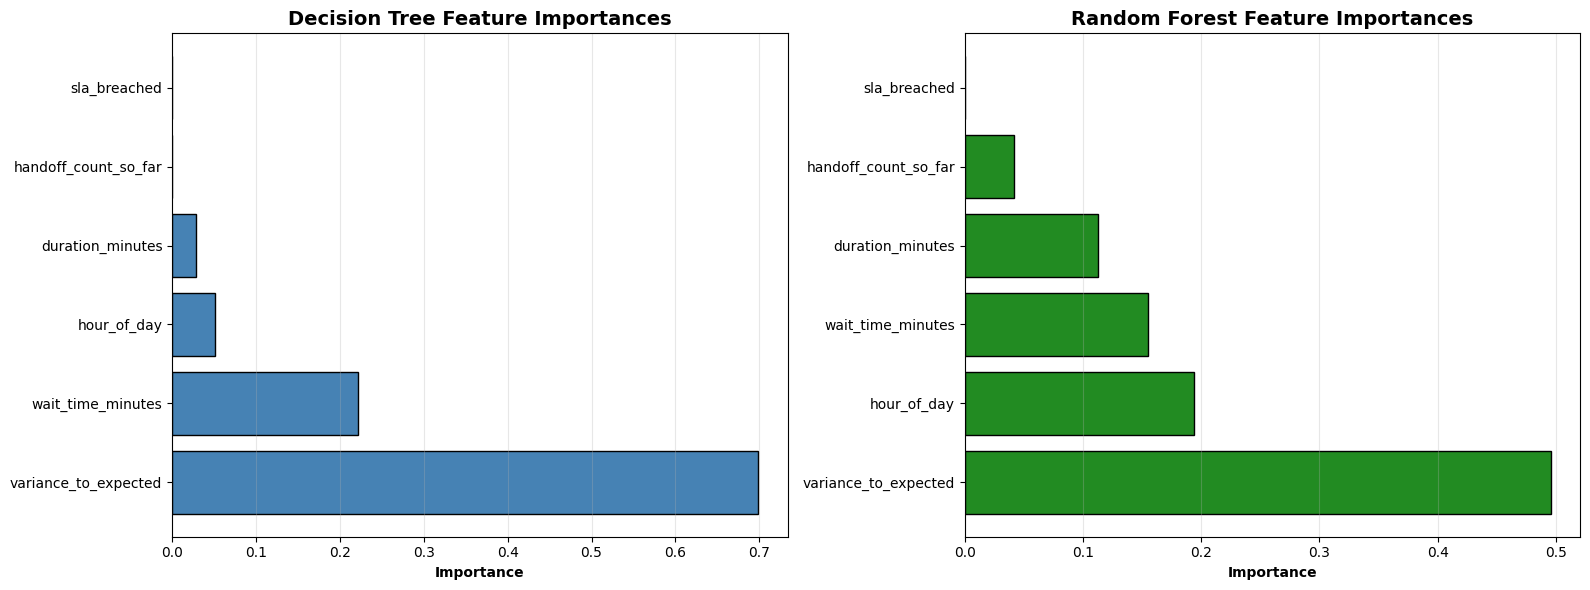

Saved: ../outputs/visualizations/model_feature_importances.png


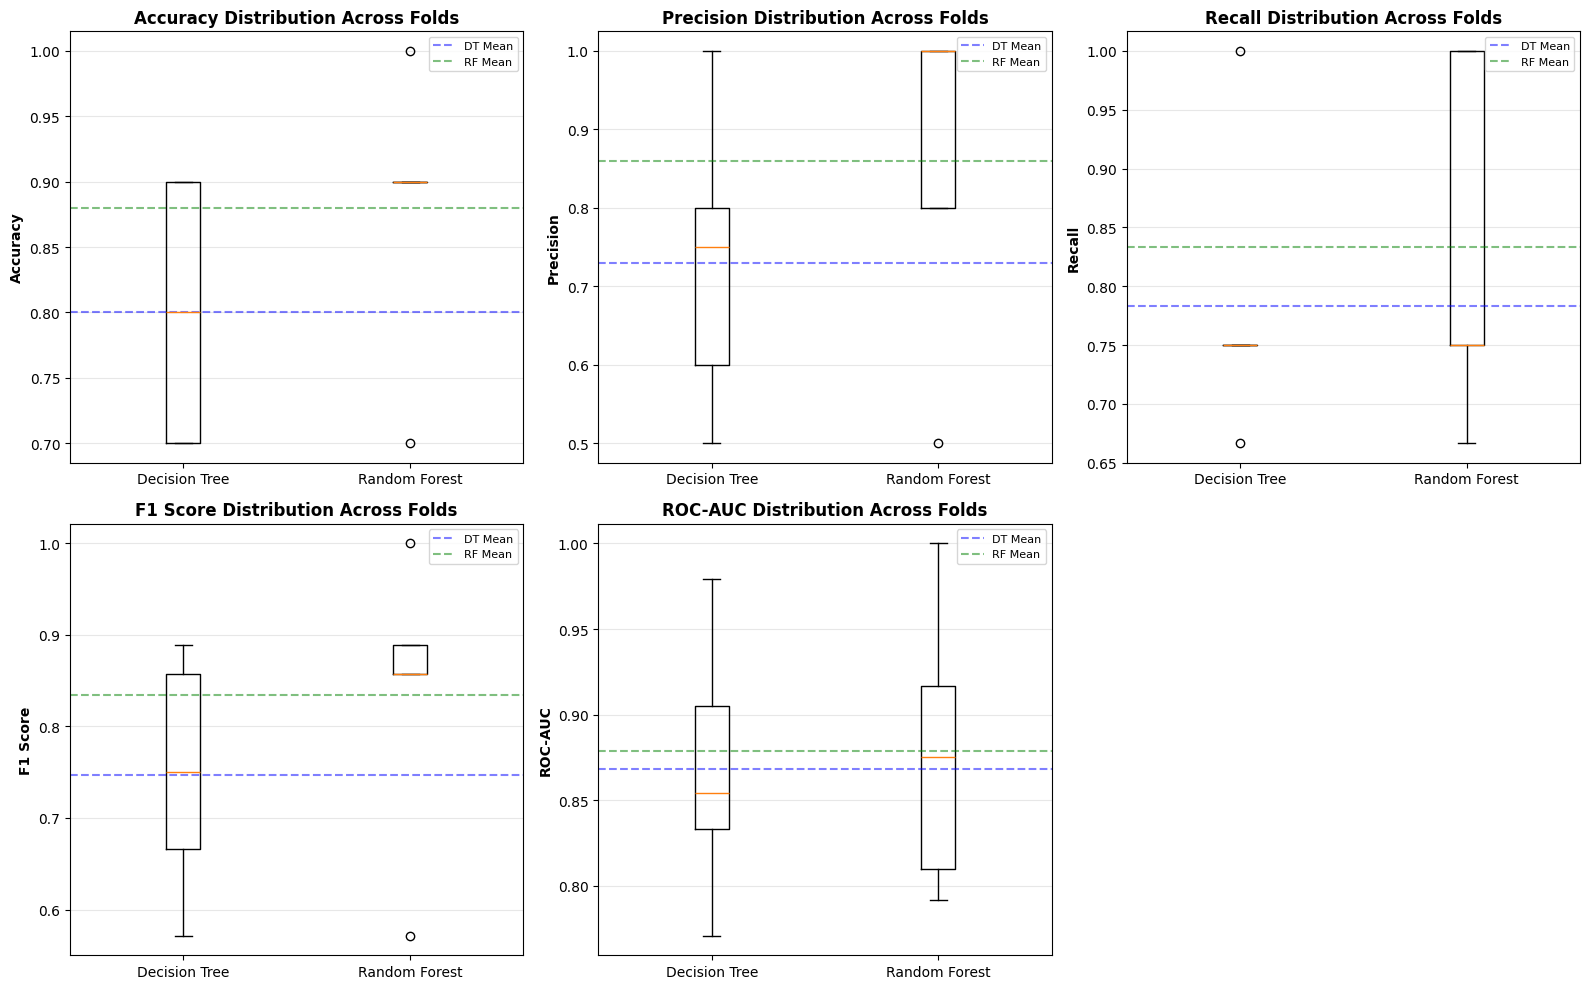

Saved: ../outputs/visualizations/model_cv_comparison.png


In [5]:

comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC', 'Overfit Gap'],
    'Decision Tree': [
        cv_results_dt['test_accuracy'].mean(),
        cv_results_dt['test_precision'].mean(),
        cv_results_dt['test_recall'].mean(),
        cv_results_dt['test_f1'].mean(),
        cv_results_dt['test_roc_auc'].mean(),
        overfit_gap
    ],
    'Random Forest': [
        cv_results_rf['test_accuracy'].mean(),
        cv_results_rf['test_precision'].mean(),
        cv_results_rf['test_recall'].mean(),
        cv_results_rf['test_f1'].mean(),
        cv_results_rf['test_roc_auc'].mean(),
        overfit_gap_rf
    ]
})

print("\n" + comparison.to_string(index=False))

# Determine winner
if cv_results_rf['test_f1'].mean() > cv_results_dt['test_f1'].mean():
    best_model = rf_model
    best_model_name = "Random Forest"
    best_f1 = cv_results_rf['test_f1'].mean()
else:
    best_model = dt_model
    best_model_name = "Decision Tree"
    best_f1 = cv_results_dt['test_f1'].mean()

print(f"\nBEST MODEL: {best_model_name} (F1 = {best_f1:.3f})")


# VISUALIZATIONS
# 1. Feature Importance Comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Decision Tree
axes[0].barh(dt_importances['feature'], dt_importances['importance'], color='steelblue', edgecolor='black')
axes[0].set_xlabel('Importance', fontweight='bold')
axes[0].set_title('Decision Tree Feature Importances', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Random Forest
axes[1].barh(rf_importances['feature'], rf_importances['importance'], color='forestgreen', edgecolor='black')
axes[1].set_xlabel('Importance', fontweight='bold')
axes[1].set_title('Random Forest Feature Importances', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
import os
os.makedirs('../outputs/visualizations', exist_ok=True)
plt.savefig('../outputs/visualizations/model_feature_importances.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: ../outputs/visualizations/model_feature_importances.png")

# 2. Cross-Validation Performance Comparison
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']

for idx, (metric, name) in enumerate(zip(metrics, metric_names)):
    dt_scores = cv_results_dt[f'test_{metric}']
    rf_scores = cv_results_rf[f'test_{metric}']
    
    axes[idx].boxplot([dt_scores, rf_scores], labels=['Decision Tree', 'Random Forest'])
    axes[idx].set_ylabel(name, fontweight='bold')
    axes[idx].set_title(f'{name} Distribution Across Folds', fontweight='bold')
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Add mean lines
    axes[idx].axhline(dt_scores.mean(), color='blue', linestyle='--', alpha=0.5, label='DT Mean')
    axes[idx].axhline(rf_scores.mean(), color='green', linestyle='--', alpha=0.5, label='RF Mean')
    axes[idx].legend(fontsize=8)

# Hide the 6th subplot
axes[5].axis('off')

plt.tight_layout()
plt.savefig('../outputs/visualizations/model_cv_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: ../outputs/visualizations/model_cv_comparison.png")

In [6]:
# Save both models
dt_package = {
    'model': dt_model,
    'model_name': 'Decision Tree',
    'features': features_to_use,
    'cv_results': {
        'accuracy': cv_results_dt['test_accuracy'].mean(),
        'precision': cv_results_dt['test_precision'].mean(),
        'recall': cv_results_dt['test_recall'].mean(),
        'f1': cv_results_dt['test_f1'].mean(),
        'roc_auc': cv_results_dt['test_roc_auc'].mean()
    },
    'feature_importances': dt_importances.to_dict(),
    'trained_on': '5k_with_proxies.csv',
    'n_samples': len(X),
    'class_distribution': y.value_counts().to_dict()
}

rf_package = {
    'model': rf_model,
    'model_name': 'Random Forest',
    'features': features_to_use,
    'cv_results': {
        'accuracy': cv_results_rf['test_accuracy'].mean(),
        'precision': cv_results_rf['test_precision'].mean(),
        'recall': cv_results_rf['test_recall'].mean(),
        'f1': cv_results_rf['test_f1'].mean(),
        'roc_auc': cv_results_rf['test_roc_auc'].mean()
    },
    'feature_importances': rf_importances.to_dict(),
    'trained_on': '5k_with_proxies.csv',
    'n_samples': len(X),
    'class_distribution': y.value_counts().to_dict()
}

from pathlib import Path

# repo_root = parent of the notebooks folder
repo_root = Path().resolve().parent
models_path = repo_root / "models"
models_path.mkdir(exist_ok=True)

print("Repo root:", repo_root)
print("Models save path:", models_path)

joblib.dump(dt_package, models_path / "decision_tree_model.pkl")
joblib.dump(rf_package, models_path / "random_forest_model.pkl")
joblib.dump(best_model, models_path / "best_model.pkl")

Repo root: /Users/anabellatrias/OITest
Models save path: /Users/anabellatrias/OITest/models


['/Users/anabellatrias/OITest/models/best_model.pkl']

# Summary

Best Model: Random Forest
F1 Score: 0.835

STRATEGY:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Trained WITHOUT proxy features (based on Milestone 2 validation failure)
Used only 6 features that work on both 5k and 2k naturally
5-fold stratified cross-validation (more reliable than single test set)
Trained Decision Tree and Random Forest
Compared performance across multiple metrics


FEATURES USED:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
1. variance_to_expected
2. duration_minutes
3. wait_time_minutes
4. handoff_count_so_far
5. hour_of_day
6. sla_breached


DECISION TREE RESULTS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Accuracy:  0.800 ± 0.089
Precision: 0.730 ± 0.172
Recall:    0.783 ± 0.113
F1 Score:  0.747 ± 0.118
ROC-AUC:   0.868 ± 0.070
Overfit Gap: 0.160


RANDOM FOREST RESULTS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Accuracy:  0.880 ± 0.098
Precision: 0.860 ± 0.196
Recall:    0.833 ± 0.139
F1 Score:  0.835 ± 0.142
ROC-AUC:   0.879 ± 0.076
Overfit Gap: 0.075


BEST MODEL: Random Forest
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
F1 Score: 0.835


TOP 3 PREDICTIVE FEATURES:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Decision Tree:
  1. variance_to_expected: 0.699
  2. wait_time_minutes: 0.222
  3. hour_of_day: 0.052

Random Forest:
  1. variance_to_expected: 0.496
  2. hour_of_day: 0.194
  3. wait_time_minutes: 0.155


Our Results: 88.0% accuracy, 0.86 precision, 0.83 recall (on 5-fold CV)

Improvements:
More reliable validation (5-fold CV vs single test split)
Fewer features (6 vs the full set) - better generalization
No proxy features - works on 2k dataset without issues
Clear feature importance from both models

NEXT STEPS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
- Business Validation on 2k Dataset
  - Apply Random Forest to 2k operational logs
  - Validate predictions using business metrics:
    * cost_usd correlation
    * rework_flag lift
    * sla_breach correlation
  - Assess if model generalizes to production-like data